# Esercizio 4
---
Qui si deve fare la stessa analisi fatta in `reconstruction_es3`, ma sul dataset "Data.root" che contiene molti più eventi e non solo i decadimenti che ci interessano

In [1]:
import ROOT
file = ROOT.TFile("../datasets/Data.root","OPEN")
tr = file.trees.events

Welcome to JupyROOT 6.26/04


In [2]:
class particle:
    def __init__(self, pt,eta,phi,e,charge,flavor):
        self.pt=pt
        self.eta=eta
        self.phi=phi
        self.e=e
        self.charge=charge
        self.flavor=flavor
        self.p4 = ROOT.TLorentzVector()
        self.p4.SetPtEtaPhiE(pt,eta,phi,e)
        
#2 Metodo per estrarla:    
def get_particle(tree=tr,var="muontracks",index=0):
    flav_dict={"muontracks":13,"electrons":11} #questi numeri sono delle convenzioni date sul PDG che permettono di identificare le particelle in qualche modo
    p = particle(getattr(tree,var+"_pt")[index],#getattr chiama dall'esterno un attributo con il nome preso come stringa
                getattr(tree,var+"_eta")[index],
                getattr(tree,var+"_phi")[index],
                getattr(tree,var+"_e")[index],
                getattr(tree,var+"_charge")[index] if hasattr(tree,var+"_charge") else 0,#nota: questo per i jet fallirà se non faccio qualcosa!
                -1*getattr(tree,var+"_charge")[index]*(flav_dict[var]) if hasattr(tree,var+"_charge") else 0)
    return p

def get_collection(tree=tr,var="muontracks"):
    particles=[get_particle(tree,var,i) for i in range(getattr(tree,var+"_size"))]
    return particles

### Tratto muoni
* Ricostruisco la massa con tutti e faccio OS e SS, vedo se esce fuori la risonanza
    * Faccio fit del picco e del rumore così da trovare le funzioni migliori
    * Provo a stimare numero di eventi sia per il rumore che per il picco
* Analizzo le caratteristiche: _chi2, isoDeposits, dz, dB_

Warning in <TFile::Append>: Replacing existing TH1: mu_mass (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: mu_mass (Potential memory leak).


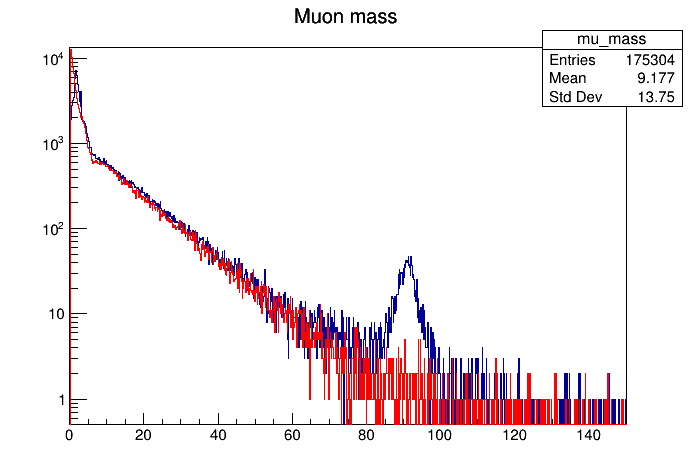

In [5]:
are_os = lambda x,y: x.charge*y.charge<0
h_mu_mass_os = ROOT.TH1F("mu_mass","Muon mass",1000,0,150) 
h_mu_mass_ss = ROOT.TH1F("mu_mass","Muon mass",1000,0,150)

c=ROOT.TCanvas()

for i in range(tr.GetEntries()):
    tr.GetEntry(i)
    muons=get_collection(tr,"muontracks")
    for mi in range(len(muons)):
        for mj in range(mi):
            if(are_os(muons[mi],muons[mj])):
                h_mu_mass_os.Fill((muons[mi].p4+muons[mj].p4).M())
            else:
                h_mu_mass_ss.Fill((muons[mi].p4+muons[mj].p4).M())
c.Draw()
c.SetLogy()
h_mu_mass_os.Draw()
h_mu_mass_ss.SetLineColor(ROOT.kRed)
h_mu_mass_ss.Draw("same")

In [ ]:
c2.Draw()
mu_bgm = 10
mu_bgM = 150

bkg = ROOT.TF1("exp_1", "[0]/[1]* TMath::Exp(-x/[1])", mu_bgm, mu_bgM)
bkg.SetParameters(1000,20)

h_mu_mass_ss.Fit(bkg,"SR")